# Stitching correction for MIRI/JWST datacubes

# Introduction

**Author**: Matteo Ceci (matteo.ceci@unifi.it)

**Latest Update**: 20 Sept 2025

___

The Mid-Infrared Instrument (MIRI) onboard the *James Webb Space Telescope* (JWST) provides unprecedented sensitivity and spatially resolved spectroscopy in the mid-infrared domain. However, MIRI integral field unit (IFU) datacubes are produced in separate spectral segments (channels and sub-bands), each with slightly different spectral coverage and flux calibrations. This segmentation introduces discontinuities and mismatches between adjoining spectral ranges, which must be corrected before any reliable analysis of the continuum or emission-line features can be performed.  

This notebook presents a step-by-step implementation of the **stitching and correction procedure** developed within the **Mid-IR Activity of Circumnuclear Line Emission** (**MIRACLE**; JWST GO program 6138; Co-PIs: C. Marconcini and A. Feltre). The method includes:  

- corrections to the World Coordinate System (WCS),  
- reprojection onto a common spatial grid,  
- interpolation onto a uniform spectral axis,  
- stitching of multiple MIRI segments into a single datacube,  
- and a flux correction through continuum fitting across overlapping regions.  

This procedure ensures a continuous combination of all MIRI channels into a homogeneous datacube, enabling robust spectral and spatial analysis.  

The methodology and its validation are described in detail in Ceci et al. (2025). 

######## If you use this tool in your research please cite: ########\
📄 Ceci et al. (2025), *A&A, submitted* — *"MIRACLE II: Unveiling the multi-phase gas interplay in the circumnuclear region of NGC 1365 via multi-cloud modeling"*  
[arXiv link](https://arxiv.org/pdf/2507.08077)

---
THE BIBTEX FOR THE PAPER IS:\
@ARTICLE{2025arXiv250708077C,\
       author = {{Ceci}, M. and {Marconcini}, C. and {Marconi}, A. and {Feltre}, A. and {Lamperti}, I. and {Belfiore}, F. and {Bertola}, E. and {Bracci}, C. and {Carniani}, S. and {Cataldi}, E. and {Cresci}, G. and {Fritz}, J. and {Ginolfi}, M. and {Hatziminaoglou}, E. and {Hirschmann}, M. and {Mingozzi}, M. and {Moreschini}, B. and {Mannucci}, F. and {Sabatini}, G. and {Salvestrini}, F. and {Scialpi}, M. and {Tozzi}, G. and {Ulivi}, L. and {Venturi}, G. and {Vidal-Garc{\'\i}a}, A. and {Vignali}, C. and {Zanchettin}, M.~V.},\
        title = "{MIRACLE II: Unveiling the multi-phase gas interplay in the circumnuclear region of NGC 1365 via multi-cloud modeling}",\
      journal = {arXiv e-prints},\
     keywords = {Astrophysics of Galaxies},\
         year = 2025,\
        month = jul,\
          eid = {arXiv:2507.08077},\
        pages = {arXiv:2507.08077},\
          doi = {10.48550/arXiv.2507.08077},\
archivePrefix = {arXiv},\
       eprint = {2507.08077},\
 primaryClass = {astro-ph.GA},\
       adsurl = {https://ui.adsabs.harvard.edu/abs/2025arXiv250708077C},\
      adsnote = {Provided by the SAO/NASA Astrophysics Data System}\
}\






## Required packages ##
The required packages with their respective versions are:


*numpy==1.26.4\
matplotlib==3.9.2\
scipy==1.13.1\
tqdm==4.66.5\
astropy==5.3.4\
reproject==0.14.1\
spectres==2.2.2*

# 1. WCS correction #

### Imports ###

In [32]:
import os
import sys
import glob
import warnings

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from tqdm import tqdm

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.utils.exceptions import AstropyWarning

from reproject import reproject_exact
from spectres import spectres


warnings.filterwarnings("ignore", message=".*FITSFixedWarning.*")
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings('ignore', category=AstropyWarning)


### Load the datacubes ###
The MRS mode of MIRI covers a total wavelength range of 4.9–27.9 $\mu$m, divided into four integral field units (IFUs), also referred to as channels (Ch1, Ch2, Ch3, and Ch4, hereafter), each further subdivided into three bands (SHORT, MEDIUM, and LONG, or A, B, and C). These channels cover slightly different fields of view (FoVs), from 3.2" $\times$ 3.7" in Ch1 to 6.6" $\times$ 7.7" in Ch4, at varying pixel size (from 0.13" in Ch1 to 0.35" in Ch4) and resolving powers (from $\sim$3700 to $\sim$1500; see e.g. Labiano et al. 2021, Argyriou et al. 2023).
\
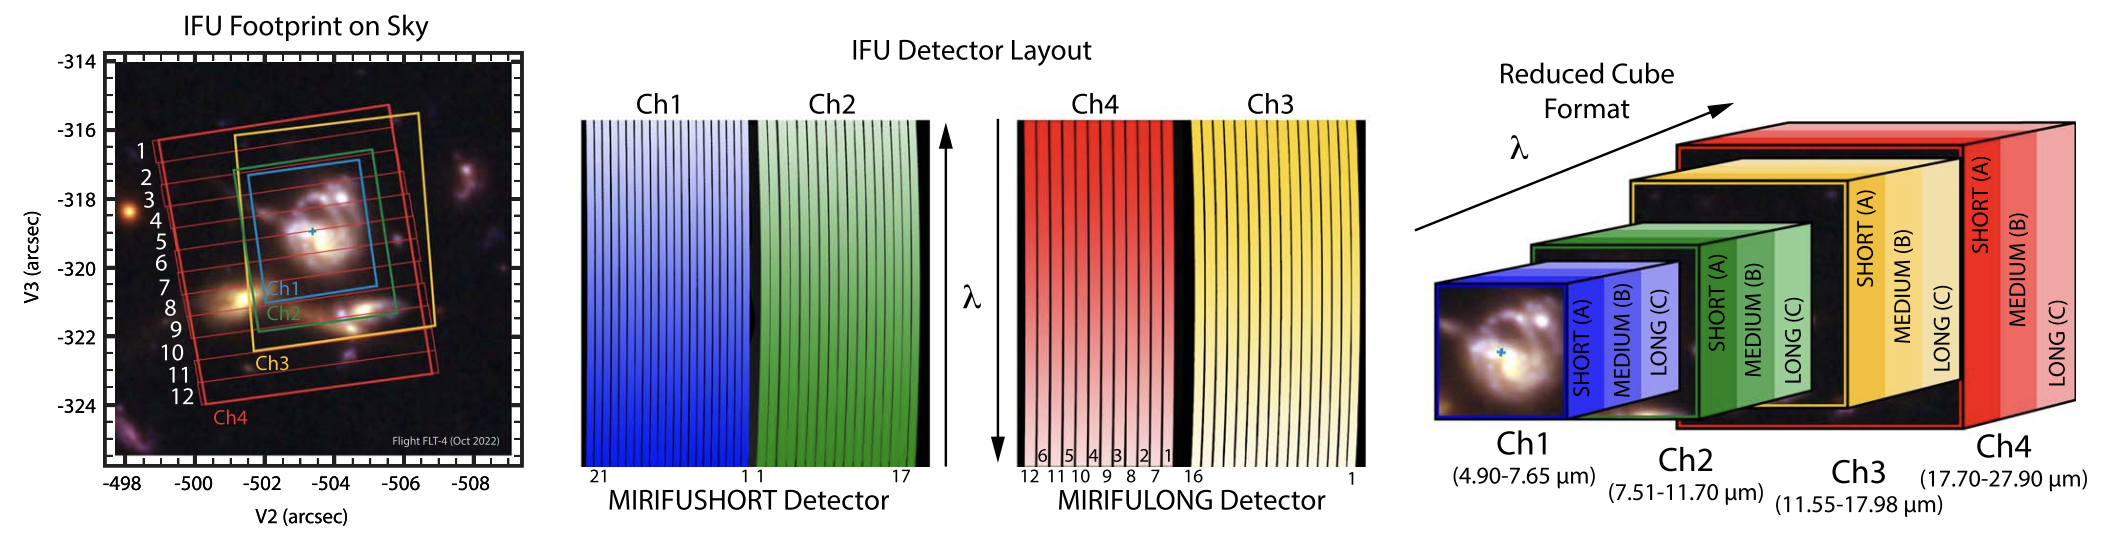  
*Figure 1. Schematic overview of the MIRI MRS IFU (adapted from Law et al. 2023).*

As shown in Law et al. (2023), the average FWHM of the MIRI/MRS PSF ranges from $\sim$0.4" in Ch1 to $\sim$0.9" in Ch4.
\
\
So in the following we will work with the following datacubes:
Ch1A, Ch1B, Ch1C, Ch2A, Ch2B, Ch2C, Ch3A, Ch3B, Ch3C, Ch4A, Ch4B, Ch4.
\
\
The MIRI datacubes of NGC 1365 used in Ceci et al. 2025 to test this notebook are available for download [here](https://drive.google.com/drive/folders/1ecxK8L4SS13SRBPYexBQmBKDDRgtOfe7?usp=sharing).

In [33]:
c = 299792.458*u.km/u.s

# Go to the "stitching" directory, which must contain all the 12 datacubes 
# to be stitched together. Each file should be named starting with "ngc".
dire = '/Users/matteoceci/Desktop/MIRACLE/MIRI data analysis/stitching'
s3dfiles = sorted(glob.glob(os.path.join(dire, 'ngc*.fits')))

cubes = []
headers = []
wlrange_overlapping = [] #### overlapping regions (for plotting purpose in block 3) 

## Load the data cube files
for file in s3dfiles:
    try:
        with fits.open(file) as hdu:
            flux = hdu[1].data
            err = hdu[2].data
            head = hdu[1].header
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue
    
    headers.append(head)
    zsize, xsize, ysize = flux.shape
    wave_start = head['CRVAL3']
    wave_step = head['CDELT3']
    
    # Define the wavelength array for the current cube
    wavelength = np.arange(wave_start, wave_start + zsize * wave_step, wave_step)
    if len(wavelength)!=zsize:
        wavelength = wave_start + wave_step * np.arange(zsize)

    cubes.append((wavelength, flux, err))
    hdu.close()
    
cubes, headers = zip(*sorted(zip(cubes, headers), key=lambda item: item[0][0][0]))
cubesnames= ['Ch1A','Ch1B','Ch1C','Ch2A','Ch2B','Ch2C','Ch3A','Ch3B','Ch3C','Ch4A','Ch4B','Ch4C' ]

if len(cubesnames) != len(cubes):
    raise ValueError(f"Number of cube names ({len(cubesnames)}) does not match number of loaded cubes ({len(cubes)}).")

# Compute the number of overlapping spectral channels between each pair of cubes
overlap_channels = []
for i in range(len(cubes) - 1):
    wavelength1, _, _ = cubes[i]
    wavelength2, _, _ = cubes[i + 1]
    
    # find the boundaries of the overlapped spectral range
    overlap_min = max(wavelength1[0], wavelength2[0])
    overlap_max = min(wavelength1[-1], wavelength2[-1])
    wlrange_overlapping.append(overlap_min)
    wlrange_overlapping.append(overlap_max)
    
    if overlap_min < overlap_max:
        # number of overlapping spectral channels
        overlap_count = np.sum((wavelength1 >= overlap_min) & (wavelength1 <= overlap_max))
        overlap_channels.append(overlap_count)
        print(f'Overlap between {cubesnames[i]} and {cubesnames[i+1]}: {overlap_count} channels')
    else:
        overlap_channels.append(0)
        print(f'No overlap between {cubesnames[i]} and {cubesnames[i+1]}')
        
    
# Determine the global wavelength range across all cubes
all_waves = np.concatenate([cube[0] for cube in cubes])
min_wave, max_wave = all_waves.min(), all_waves.max()
final_wave = np.linspace(min_wave, max_wave, len(all_waves)-sum(overlap_channels))

Overlap between Ch1A and Ch1B: 100 channels
Overlap between Ch1B and Ch1C: 125 channels
Overlap between Ch1C and Ch2A: 174 channels
Overlap between Ch2A and Ch2B: 77 channels
Overlap between Ch2B and Ch2C: 93 channels
Overlap between Ch2C and Ch3A: 114 channels
Overlap between Ch3A and Ch3B: 52 channels
Overlap between Ch3B and Ch3C: 64 channels
Overlap between Ch3C and Ch4A: 111 channels
Overlap between Ch4A and Ch4B: 43 channels
Overlap between Ch4B and Ch4C: 13 channels


### Compute astronometric correction ###
We compute the astrometry correction for each band (A,B,C) - because in the same band we should have the same astrometry error. \
We find the center of the PSF with a 2D gaussin fit for each datacubes and register it to the position of the nucleus 'nuc_coord'.


In [34]:
def gaussian_2d(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    x, y = xy
    x0, y0 = float(x0), float(y0)
    a = (np.cos(theta)**2 / (2 * sigma_x**2)) + (np.sin(theta)**2 / (2 * sigma_y**2))
    b = (-np.sin(2 * theta) / (4 * sigma_x**2)) + (np.sin(2 * theta) / (4 * sigma_y**2))
    c = (np.sin(theta)**2 / (2 * sigma_x**2)) + (np.cos(theta)**2 / (2 * sigma_y**2))
    z = offset + amplitude * np.exp(-(a * (x - x0)**2 + 2 * b * (x - x0) * (y - y0) + c * (y - y0)**2))
    return z.ravel()  

nuc_coord = ['3:33:36.36719229', '-36:08:25.36998589'] 
nuc_coord = SkyCoord(nuc_coord[0], nuc_coord[1], unit=(u.hourangle, u.deg))

## We use the Ch3 because in the specific case of NGC1365 that is the channel with the highest angular resolution with the PSF entirely in the FoV
imA = np.nansum(cubes[6][1], axis=0)  ## Ch3A
headA = headers[6]
wcsA = WCS(headA).sub([1, 2])

imB = np.nansum(cubes[7][1], axis=0)  ## Ch3B
headB = headers[7]
wcsB = WCS(headB).sub([1, 2])

imC = np.nansum(cubes[8][1], axis=0)  ## Ch3C
headC = headers[8]
wcsC = WCS(headC).sub([1, 2])

#################### Channel A ####################
# Find the peak of the image
y_peak, x_peak = np.unravel_index(np.nanargmax(imA), imA.shape)
guess_amplitude = imA[y_peak, x_peak]
# Define x, y coordinates for fitting
y, x = np.indices(imA.shape)
# Initial guesses for the fit
initial_guess = [
    guess_amplitude,        # Amplitude
    x_peak,                 # Center x
    y_peak,                 # Center y
    5,                      # sigma_x
    5,                      # sigma_y
    0,                      # Theta
    np.median(imA)     # Offset
]

# Perform the fit
popt, _ = curve_fit(
    gaussian_2d,
    (x, y),                  # x, y coordinates as input
    imA.ravel(),        # Flattened observed data
    p0=initial_guess,
    bounds=(
        [0, 0, 0, 0, 0, -np.pi, -np.inf],  # Lower bounds
        [np.inf, imA.shape[1], imA.shape[0], np.inf, np.inf, np.pi, np.inf]  # Upper bounds
    )
)
# Optimal parameters found
(amplitude, x0, y0, sigma_x, sigma_y, theta, offset) = popt
# Compute pixel shift between fitted center and X-ray nucleus coordinates
delta_x_pix = x0 - wcsA.world_to_pixel(nuc_coord)[0]
delta_y_pix = y0 - wcsA.world_to_pixel(nuc_coord)[1]
DX_A = delta_x_pix * abs(headA['CDELT1']) * 3600
DY_A = delta_y_pix * abs(headA['CDELT1']) * 3600

# Print WCS shifts
print("--- WCS A ---")
print("Delta RA: ", DX_A)
print("Delta DEC:", DY_A)
print("Delta pixel:", delta_x_pix, delta_y_pix)



#################### Channel B ####################
# Find the peak of the image
y_peak, x_peak = np.unravel_index(np.nanargmax(imB), imB.shape)
guess_amplitude = imB[y_peak, x_peak]
# Define x, y coordinates for fitting
y, x = np.indices(imB.shape)
# Initial guesses for the fit
initial_guess = [
    guess_amplitude,        # Amplitude
    x_peak,                 # Center x
    y_peak,                 # Center y
    5,                      # sigma_x
    5,                      # sigma_y
    0,                      # Theta
    np.median(imB)     # Offset
]

# Perform the fit
popt, _ = curve_fit(
    gaussian_2d,
    (x, y),                  # x, y coordinates as input
    imB.ravel(),        # Flattened observed data
    p0=initial_guess,
    bounds=(
        [0, 0, 0, 0, 0, -np.pi, -np.inf],  # Lower bounds
        [np.inf, imB.shape[1], imB.shape[0], np.inf, np.inf, np.pi, np.inf]  # Upper bounds
    )
)
# Optimal parameters found
(amplitude, x0, y0, sigma_x, sigma_y, theta, offset) = popt
# Compute pixel shift between fitted center and X-ray nucleus coordinates
delta_x_pix = x0 - wcsB.world_to_pixel(nuc_coord)[0]
delta_y_pix = y0 - wcsB.world_to_pixel(nuc_coord)[1]
DX_B = delta_x_pix * abs(headB['CDELT1']) * 3600
DY_B = delta_y_pix * abs(headB['CDELT1']) * 3600

# Print WCS shifts
print("--- WCS B ---")
print("Delta RA: ", DX_B)
print("Delta DEC:", DY_B)
print("Delta pixel:", delta_x_pix, delta_y_pix)



#################### Channel C ####################
# Find the peak of the image
y_peak, x_peak = np.unravel_index(np.nanargmax(imC), imC.shape)
guess_amplitude = imC[y_peak, x_peak]
# Define x, y coordinates for fitting
y, x = np.indices(imC.shape)
# Initial guesses for the fit
initial_guess = [
    guess_amplitude,        # Amplitude
    x_peak,                 # Center x
    y_peak,                 # Center y
    5,                      # sigma_x
    5,                      # sigma_y
    0,                      # Theta
    np.median(imC)     # Offset
]

# Perform the fit
popt, _ = curve_fit(
    gaussian_2d,
    (x, y),                  # x, y coordinates as input
    imC.ravel(),        # Flattened observed data
    p0=initial_guess,
    bounds=(
        [0, 0, 0, 0, 0, -np.pi, -np.inf],  # Lower bounds
        [np.inf, imC.shape[1], imC.shape[0], np.inf, np.inf, np.pi, np.inf]  # Upper bounds
    )
)
# Optimal parameters found
(amplitude, x0, y0, sigma_x, sigma_y, theta, offset) = popt
# Compute pixel shift between fitted center and X-ray nucleus coordinates
delta_x_pix = x0 - wcsC.world_to_pixel(nuc_coord)[0]
delta_y_pix = y0 - wcsC.world_to_pixel(nuc_coord)[1]
DX_C = delta_x_pix * abs(headC['CDELT1']) * 3600
DY_C = delta_y_pix * abs(headC['CDELT1']) * 3600

# Print WCS shifts
print("--- WCS C ---")
print("Delta RA: ", DX_C)
print("Delta DEC:", DY_C)
print("Delta pixel:", delta_x_pix, delta_y_pix)



--- WCS A ---
Delta RA:  0.008597126390669839
Delta DEC: -0.2655694867397375
Delta pixel: 0.04298563131281341 -1.3278474139122203
--- WCS B ---
Delta RA:  0.02564773866061858
Delta DEC: -0.2713476591688089
Delta pixel: 0.12823869139218758 -1.3567382756270696
--- WCS C ---
Delta RA:  -0.030097674333494195
Delta DEC: -0.29927463051948383
Delta pixel: -0.15048836942501964 -1.4963731302997232


### Apply WCS Correction ###
Here we apply the astrometric correction for each band (A, B, C) using the shifts computed in the previous block.

The WCS correction can be skipped (for example, if the datacubes are already registered) by setting `wcs_correction = False`.


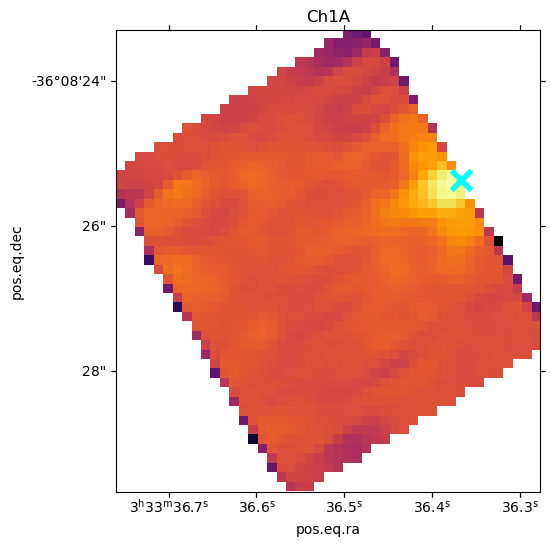

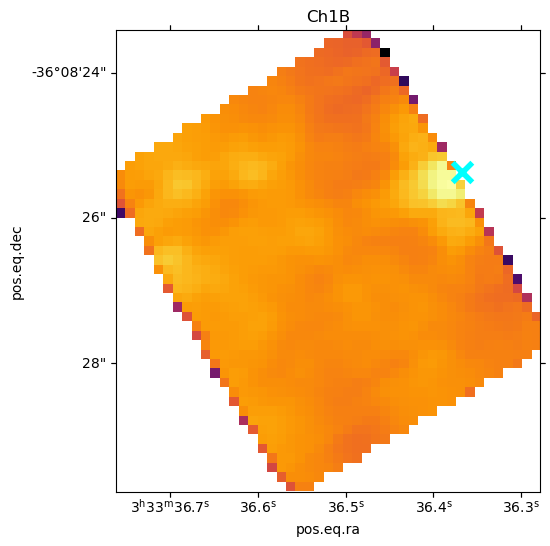

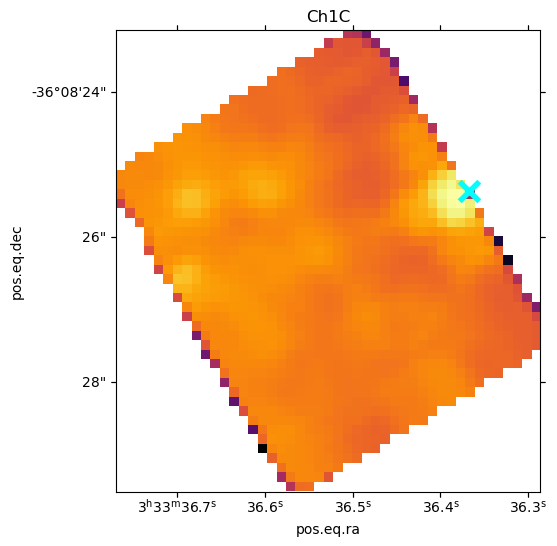

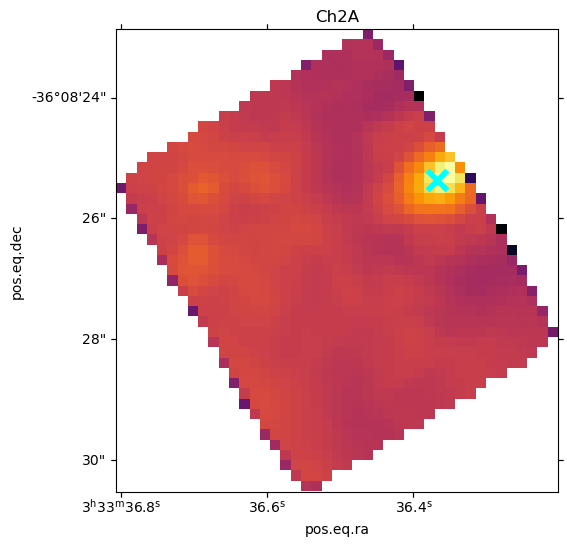

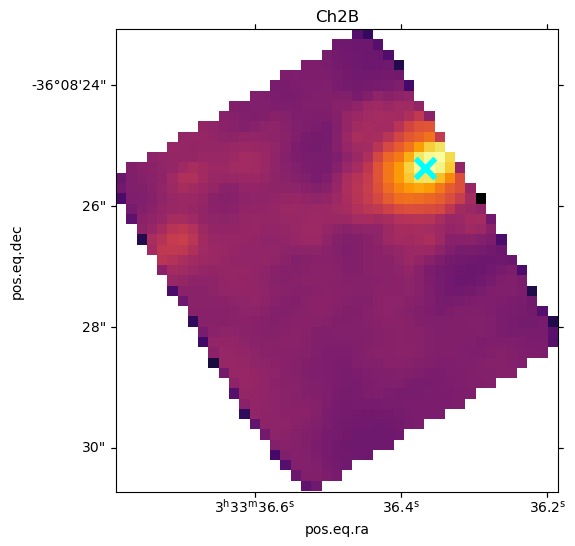

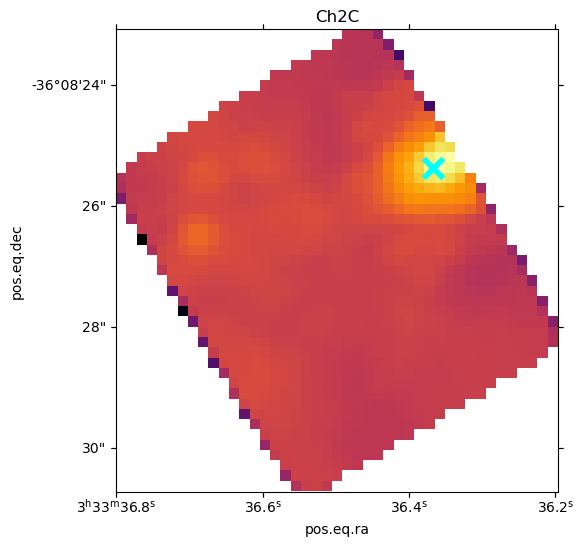

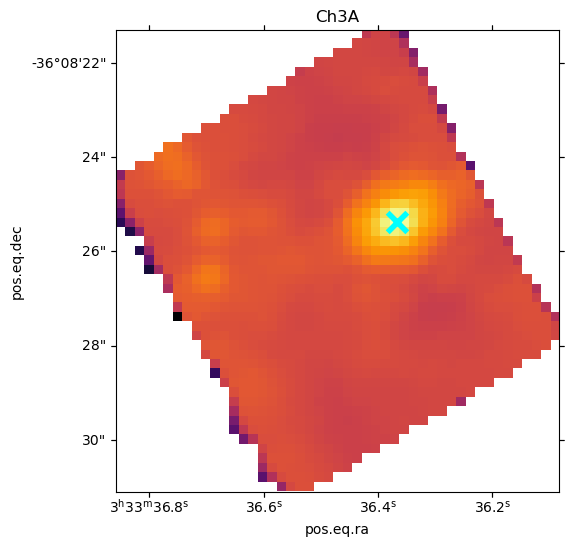

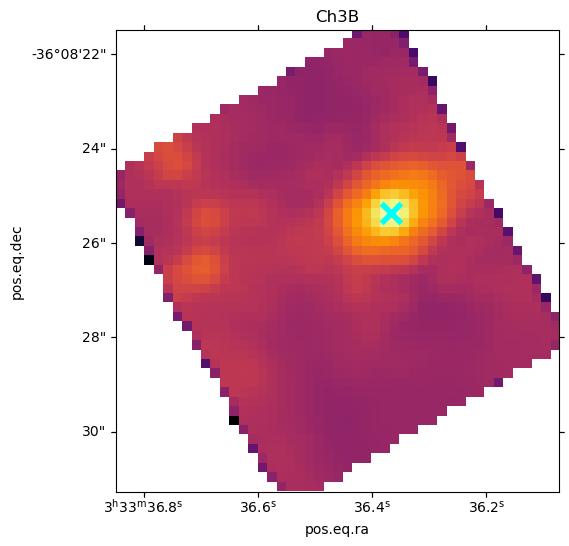

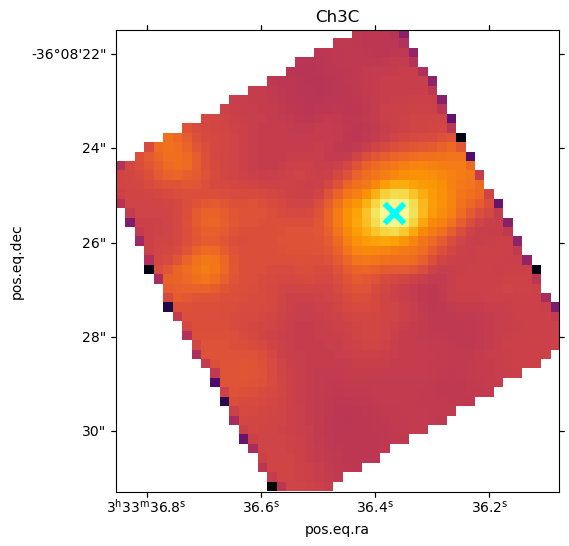

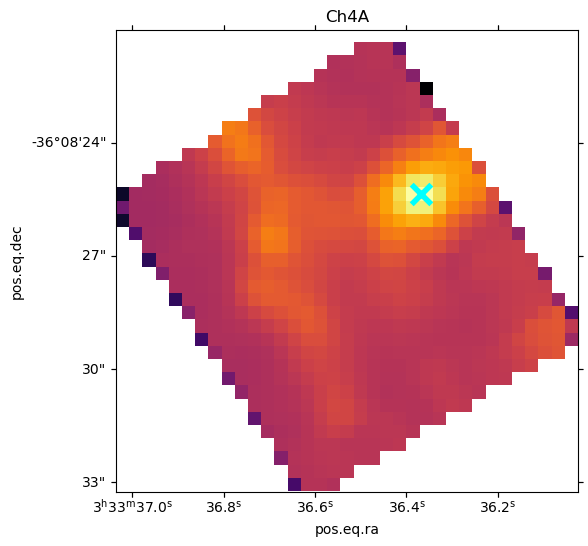

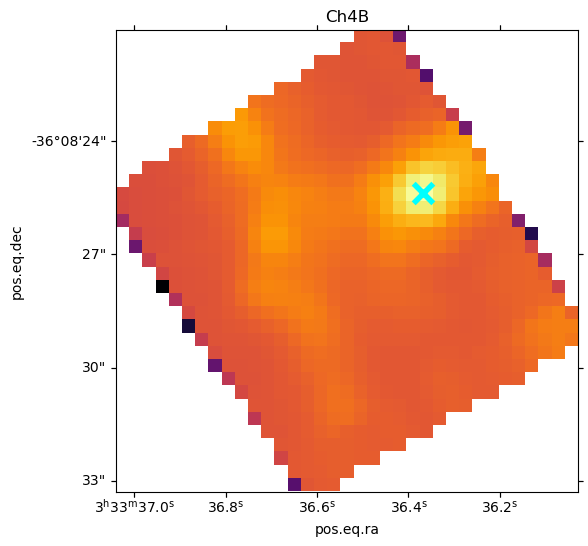

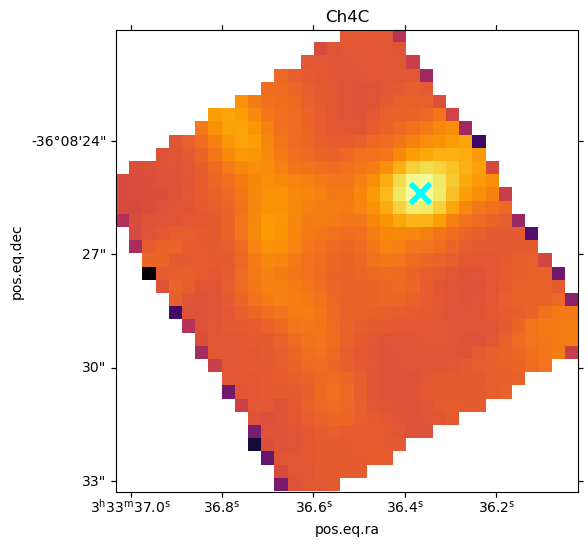

In [35]:
wcs_correction = True

cubes = list(cubes)  # from tuple to list

wcs_list = []
warnings.filterwarnings("ignore", category=UserWarning, module='astropy.wcs.wcs')


for i in range(len(cubes)):
    wcs_list.append(WCS(headers[i]).sub([1, 2]))
    
    if wcs_correction == True:
        if 'A' in cubesnames[i]:
            arcsec_to_pixel_x, arcsec_to_pixel_y = headers[i]['CDELT1']*3600,headers[i]['CDELT2']*3600
            delta_x_pix, delta_y_pix = DX_A/arcsec_to_pixel_x,  DY_A/arcsec_to_pixel_y
            wcs_list[i].wcs.crpix[0] += delta_x_pix
            wcs_list[i].wcs.crpix[1] += delta_y_pix
        elif 'B' in cubesnames[i]:
            arcsec_to_pixel_x, arcsec_to_pixel_y = headers[i]['CDELT1']*3600,headers[i]['CDELT2']*3600
            delta_x_pix, delta_y_pix = DX_B/arcsec_to_pixel_x,  DY_B/arcsec_to_pixel_y
            wcs_list[i].wcs.crpix[0] += delta_x_pix
            wcs_list[i].wcs.crpix[1] += delta_y_pix       
        elif 'C' in cubesnames[i]:
            arcsec_to_pixel_x, arcsec_to_pixel_y = headers[i]['CDELT1']*3600,headers[i]['CDELT2']*3600
            delta_x_pix, delta_y_pix = DX_C/arcsec_to_pixel_x,  DY_C/arcsec_to_pixel_y
            wcs_list[i].wcs.crpix[0] += delta_x_pix
            wcs_list[i].wcs.crpix[1] += delta_y_pix 
        
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection=wcs_list[i])
    im = np.nansum(cubes[i][1], axis=0)
    ax.imshow(np.log10(im), origin='lower',cmap='inferno')
    ax.scatter(nuc_coord.ra, nuc_coord.dec, transform=ax.get_transform('icrs'), marker='x', s=200, color='cyan',lw=4)
    ax.set_title(cubesnames[i])
    plt.show()

# 2. Pixel size correction #
Here we rebin every datacubes to the pixel size to the one of the worst channel (i.e. Ch4).
\
We apply this with the function 'reproject_exact', which has flux conservation. 


------------ Ch1A ------------
Size trasformation:  (49, 45) -> (35, 35)
Error in flux conserv =  0.00764


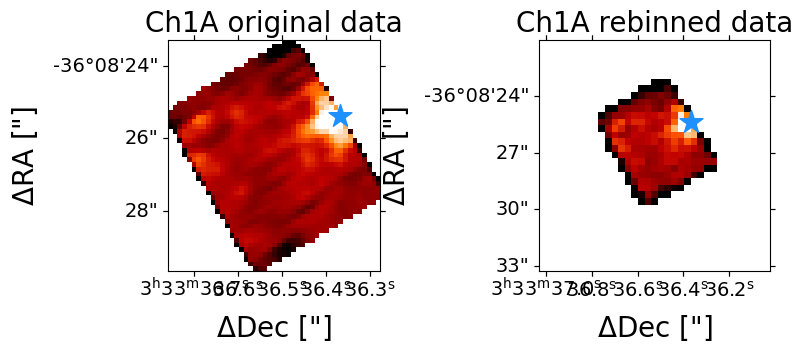


------------ Ch1B ------------
Size trasformation:  (49, 45) -> (35, 35)
Error in flux conserv =  0.0084


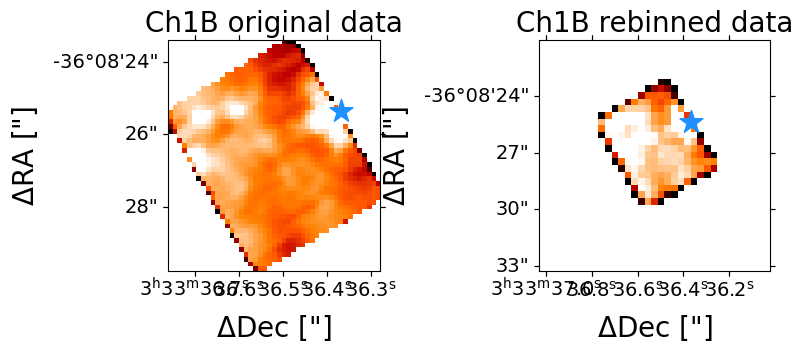


------------ Ch1C ------------
Size trasformation:  (49, 45) -> (35, 35)
Error in flux conserv =  0.00443


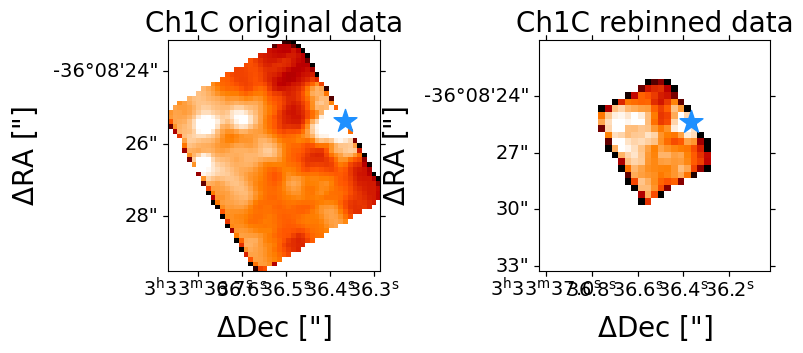


------------ Ch2A ------------
Size trasformation:  (45, 43) -> (35, 35)
Error in flux conserv =  0.0017


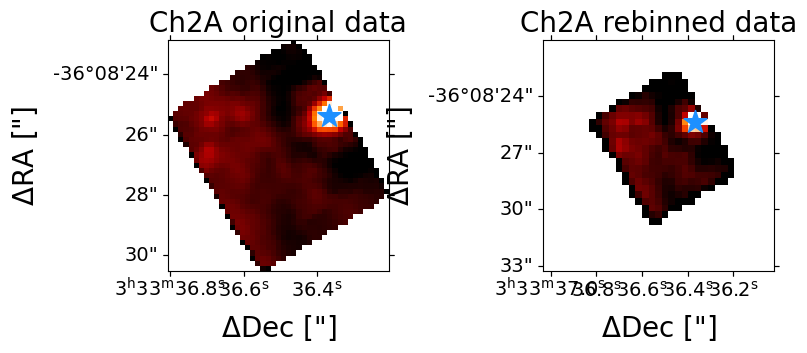


------------ Ch2B ------------
Size trasformation:  (45, 43) -> (35, 35)
Error in flux conserv =  0.000872


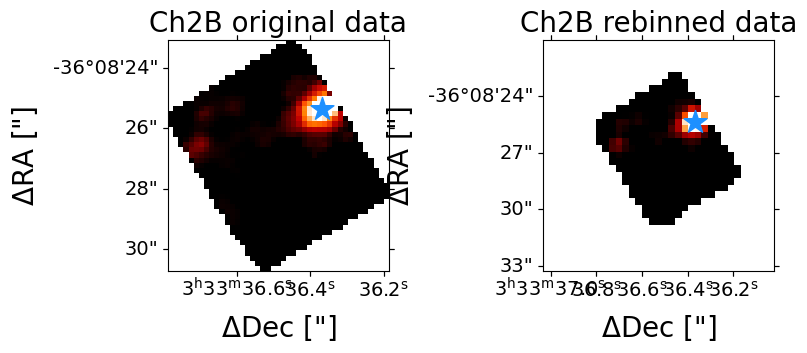


------------ Ch2C ------------
Size trasformation:  (45, 43) -> (35, 35)
Error in flux conserv =  0.00245


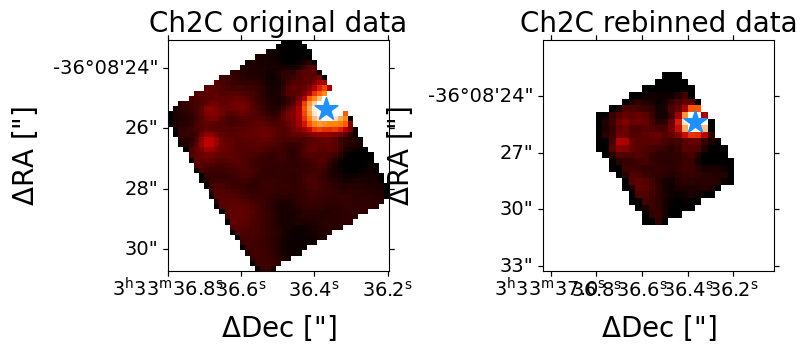


------------ Ch3A ------------
Size trasformation:  (49, 47) -> (35, 35)
Error in flux conserv =  0.00221


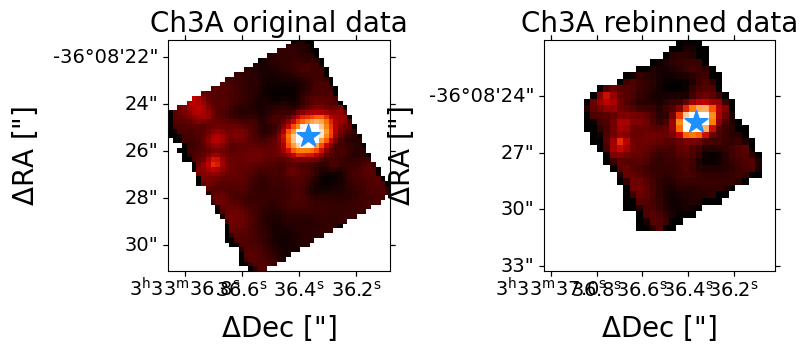


------------ Ch3B ------------
Size trasformation:  (49, 47) -> (35, 35)
Error in flux conserv =  0.00391


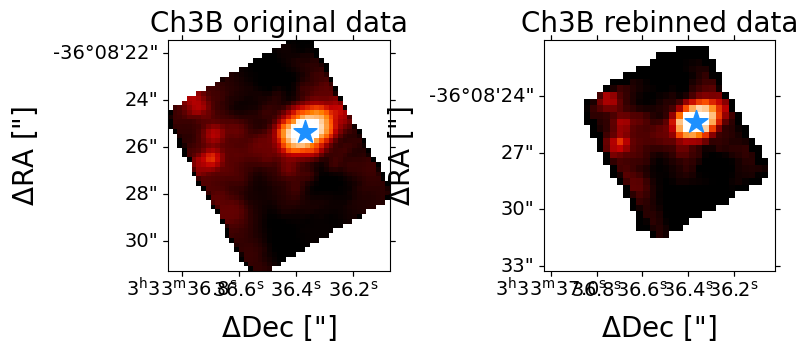


------------ Ch3C ------------
Size trasformation:  (49, 47) -> (35, 35)
Error in flux conserv =  0.00515


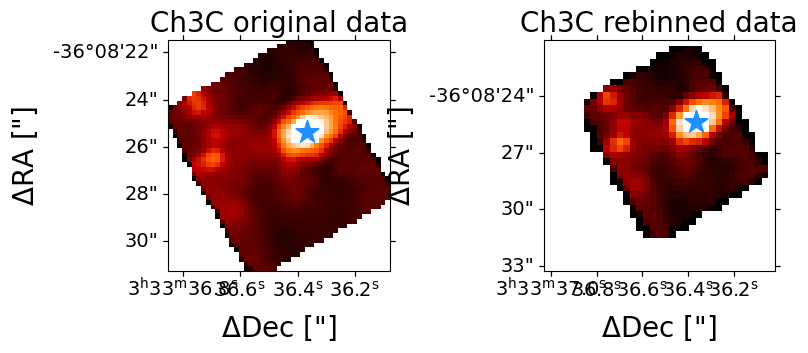


------------ Ch4A ------------
Reprojection not needed!


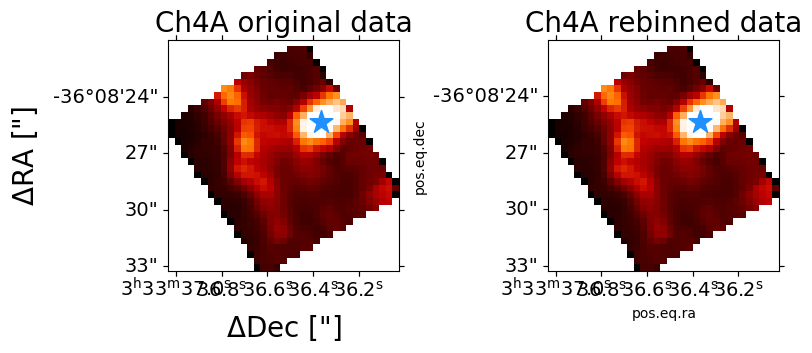


------------ Ch4B ------------
Reprojection not needed!


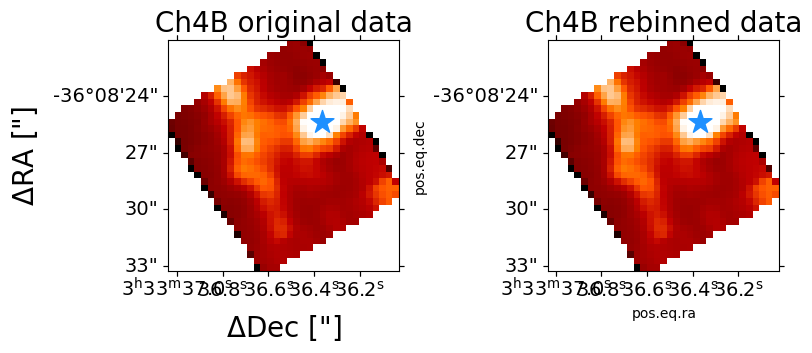


------------ Ch4C ------------
Reprojection not needed!


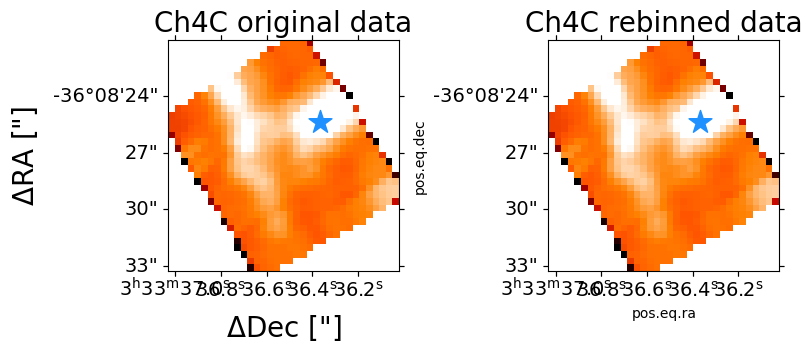

In [36]:
## Use the last cube (Ch4C) as final wcs 
wcs_fin = wcs_list[-1]
cube_fin = cubes[-1][1]
err_fin = cubes[-1][2]
header_fin = headers[-1]
size_fin = cubes[-1][1].shape[1:]   ## (y,x) size

aligned_cubes = []
aligned_errors = []


for i in range(len(cubes)):

    cube_orig = cubes[i][1]
    err_orig = cubes[i][2]
    header_orig = headers[i]
    wcs_orig = wcs_list[i]
    size_orig = cube_orig.shape[1:]   ## (y,x) size

    cube_orig = np.nan_to_num(cube_orig)
    err_orig = np.nan_to_num(err_orig)

    fig = plt.figure(figsize=(9, 3))
    
    ## plot original data
    ax1 = fig.add_subplot(121, projection=wcs_orig)
    im1 = np.nansum(cube_orig, axis=0)
    # im1[im1==0.] = np.nan
    im1 = np.log10(im1)
    
    med1 = np.nanmedian(im1)
    max1 = np.nanmax(im1)
    ax1.imshow(im1, origin='lower', cmap='gist_heat', vmin=0.7*max1, vmax=0.9*max1)
    ax1.scatter(
        nuc_coord.ra, nuc_coord.dec, 
        transform=ax1.get_transform('icrs'), 
        marker='*', s=300, color='dodgerblue', lw=1)
    ax1.set_title( cubesnames[i] + " original data", fontsize=20)
    
    ax1.set_xlabel( r'$\Delta$Dec ["]',fontsize=20)
    ax1.set_ylabel( r'$\Delta$RA ["]',fontsize=20)
    ax1.coords[0].set_ticklabel(size=14)  # x axes (RA)
    ax1.coords[1].set_ticklabel(size=14)  # y axes (Dec)
    
    ## apply the reprojection in the ch!=4C
    ## NB sometimes 4A, 4B could have different size respect to Ch4C -> we need to resample them as well in this case!
    
    if ('4' not in cubesnames[i]) or (size_orig != size_fin) :  
        aligned_data, _ = reproject_exact((cube_orig, wcs_orig), wcs_fin, shape_out=(np.shape(cube_fin)[1], np.shape(cube_fin)[2]))
        aligned_cubes.append(aligned_data)
        aligned_data_err, _ = reproject_exact((err_orig, wcs_orig), wcs_fin, shape_out=(np.shape(err_fin)[1], np.shape(err_fin)[2]))
        aligned_errors.append(aligned_data_err)
        
        ### PLOT the FoVs
        ax2 = fig.add_subplot(122, projection=wcs_fin)
        im2 = np.nansum(aligned_data, axis=0)
        im2 = np.log10(im2)
        im2[im2== -np.inf] = np.nan
        
        med2 = np.nanmedian(im2)  
        max2 = np.nanmax(im2)    
        ax2.imshow(im2, origin='lower', cmap='gist_heat', vmin=0.72*max2, vmax=0.9*max2)
        ax2.scatter(
            nuc_coord.ra, nuc_coord.dec, 
            transform=ax2.get_transform('icrs'), 
            marker='*', s=300, color='dodgerblue', lw=1)
        
        ## check flux conserv
        pix_ar_1 = header_orig['PIXAR_SR']  # Nominal pixel area in arcsec²
        total_flux_original = np.nansum(cube_orig) * pix_ar_1
        pix_ar_2 = header_fin['PIXAR_SR'] 
        total_flux_reprojected = np.nansum(aligned_data) * pix_ar_2
        err = abs(total_flux_original - total_flux_reprojected)/total_flux_original
 
        err_str = f"{err:.3g}"
        print('\n------------ %s ------------' %cubesnames[i])
        print('Size trasformation: ', size_orig, '->', size_fin)
        print("Error in flux conserv = ", err_str)
        # ax2.set_title(cubesnames[i] + " rebinned data\n Error in flux conserv = " + err_str, fontsize=14)
        ax2.set_title(cubesnames[i] + " rebinned data", fontsize=20)
        
        ax2.coords[0].set_ticklabel(size=14)  # x axes (RA)
        ax2.coords[1].set_ticklabel(size=14)  # y axes (Dec)
        ax2.set_xlabel( r'$\Delta$Dec ["]',fontsize=20)
        ax2.set_ylabel( r'$\Delta$RA ["]',fontsize=20)
        
        plt.show()
        
    else: ## if you are in ch=4C you don't need reprojection!!
        aligned_cubes.append(cube_orig)
        aligned_errors.append(err_orig)
        
        ### PLOT the FoVs
        ax2 = fig.add_subplot(122, projection=wcs_fin)
        im2 = np.nansum(cube_orig, axis=0)
        im2 = np.log10(im2)
        # im2[im2==0.] = np.nan
        med2 = np.nanmedian(im2)   
        max2 = np.nanmax(im2)

        ax2.imshow(im2, origin='lower', cmap='gist_heat',  vmin=0.7*max2, vmax=0.9*max2)
        ax2.scatter(
            nuc_coord.ra, nuc_coord.dec, 
            transform=ax2.get_transform('icrs'), 
            marker='*', s=300, color='dodgerblue', lw=1)
        ax2.set_title(cubesnames[i] + " rebinned data", fontsize=20)
        
        ax2.coords[0].set_ticklabel(size=14)  # x axes (RA)
        ax2.coords[1].set_ticklabel(size=14)  # y axes (Dec)
        # ax2.set_xlabel( r'$\Delta$Dec ["]',fontsize=20)
        # ax2.set_ylabel( r'$\Delta$RA ["]',fontsize=20)
        
        print('\n------------ %s ------------' %cubesnames[i])
        print('Reprojection not needed!')
        
        plt.show()
    

### Check spectra (pre stitching) ###
We plot know the spectra extract from the same spatial region in all the 12 reprojected datacubes.

NB after the pixel size correction, each cube has the same angular dimension, so using Jy/sr or Jy only differs by a multiplicative factor common to all cubes

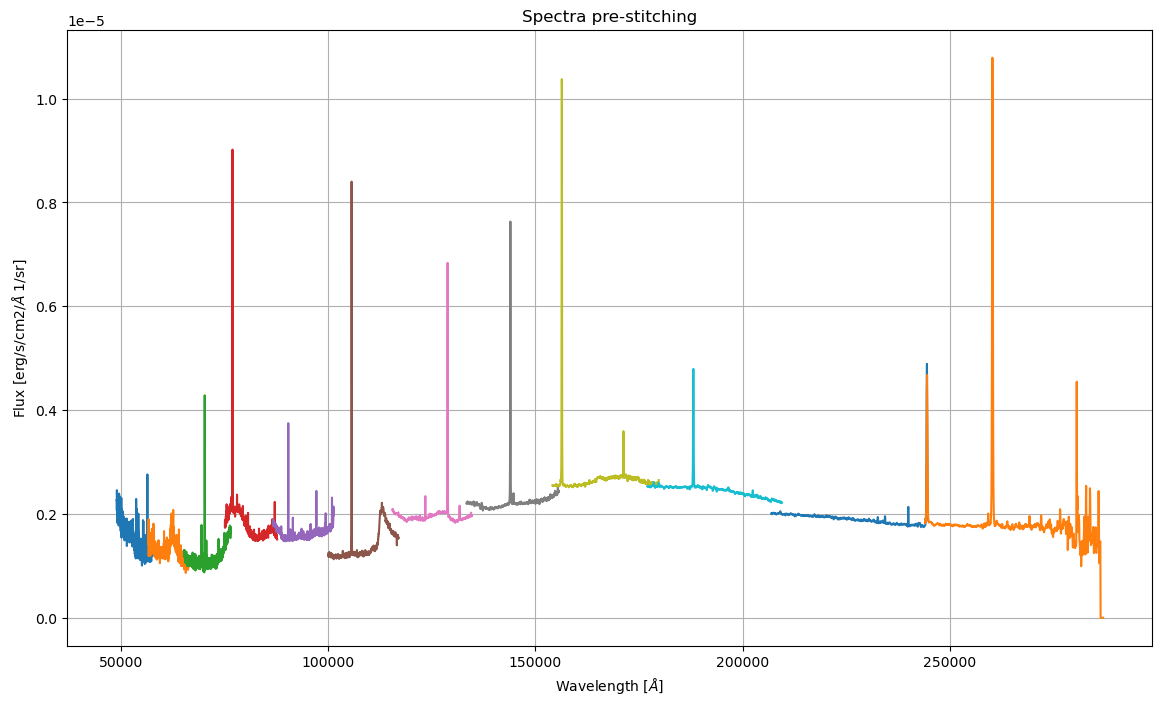

In [37]:
# Select an example pixel (and radius) from which to extract a test spectrum.
# This pixel will be used as an example in all 12 datacubes
x0, y0 = 20,20
r = 0

plt.figure(figsize=(14, 8))

for i in range(len(aligned_cubes)):
    cube = aligned_cubes[i]
    cube_err = aligned_errors[i]
    wl = cubes[i][0]      
    
    spec = 0
    err = 0
    for ix in range(im2.shape[1]):
        for iy in range(im2.shape[0]):
            if (ix-x0)**2 + (iy-y0)**2 <= r**2:
                spec += cube[:,iy,ix]
                err += cube_err[:,iy,ix]
            
    # plt.plot(wl,cube[:,y0,x0])
    # plt.plot(wl,spec )
    plt.plot(wl*1e4,spec*1e6*1e-23* (c.to(u.AA/u.s)).value  /(wl*1e4)**2   )  ## from [Jy/sr] to [erg/s/cm2/AA 1/sr]
    

plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [erg/s/cm2/$\AA$ 1/sr]')  
plt.title('Spectra pre-stitching')
plt.grid()

plt.show()


# 3. Stitching #
We correct now the flux discontinuities between sub-channels.
\
Do it respect the last channel (i.e. Ch4), because it has the largest FoV.


In [38]:
plot_comparison = 0  ## plot before and after stitching for a specific spaxel x0,y0 (tune the axes limits!)
plot_additive = 0  ## plot stitched spectrum after each step adding the new ones, for a specific spaxel x0,y0

# Select an example pixel from which to extract a test spectrum and check the stitching with plot_comparison or plot_additive
x0 = 17
y0 = 17

def scaling_factor(wave1, flux1, wave2, flux2):
    """
    Computes the scaling factor between two spectra in the common wl channels
    """

    # clean NaN
    valid1 = ~np.isnan(flux1)
    valid2 = ~np.isnan(flux2)
    wave1, flux1 = wave1[valid1], flux1[valid1]
    wave2, flux2 = wave2[valid2], flux2[valid2]
    
    
    # Check overlap
    if wave1.size == 0 or wave2.size == 0:
        return 1.0

    common_wave_min = max(wave1.min(), wave2.min())
    common_wave_max = min(wave1.max(), wave2.max())
    if common_wave_min >= common_wave_max:
        return 1.0

    # overlapping masks
    mask1 = (wave1 >= common_wave_min) & (wave1 <= common_wave_max)
    mask2 = (wave2 >= common_wave_min) & (wave2 <= common_wave_max)
    wave1_overlap = wave1[mask1]
    flux1_overlap = flux1[mask1]
    wave2_overlap = wave2[mask2]
    flux2_overlap = flux2[mask2]

    # plt.step(wave1_overlap,flux1_overlap)
    # plt.step(wave2_overlap,flux2_overlap)
    # plt.show()

    # Original area before the interpolation
    deltawl1 = np.median(np.diff(wave1_overlap))
    deltawl2 = np.median(np.diff(wave2_overlap))
    area_flux1_orig = np.nansum(flux1_overlap * c.value / (wave1_overlap**2) * deltawl1)
    area_flux2_orig = np.nansum(flux2_overlap * c.value / (wave2_overlap**2) * deltawl2)
    
    ## to ensure flux conservation
    factor_corrected = area_flux1_orig / area_flux2_orig

    return factor_corrected

    

# Initialize final cube arrays
ny, nx = np.shape(aligned_cubes[-1][1])  # Get spatial dimensions from the first cube
final_flux = np.zeros((len(final_wave), ny, nx))
final_err = np.zeros((len(final_wave), ny, nx))
scaling_factors, scaling_uncertainties = np.ones((len(aligned_cubes),ny, nx)), np.ones((ny, nx))

cube_4plots = np.zeros((len(final_wave), ny, nx))
error_4plots = np.zeros((len(final_wave), ny, nx))


# Loop over each spatial pixel and stitch spectra
for y in tqdm(range(ny), desc="Stitching slice", total=ny):
    for x in range(nx):
        stitched_wave = cubes[-1][0]  # Start with the wavelength of the first cube
        stitched_flux = aligned_cubes[-1][:, y, x]
        stitched_error = aligned_errors[-1][:, y, x]
       
        for i in range(len(aligned_cubes)-1,0,-1):
            
            wave_succ, flux_succ, err_succ = stitched_wave, stitched_flux, stitched_error
            wave_curr, flux_curr, err_curr = cubes[i-1][0], aligned_cubes[i-1][:, y, x], aligned_errors[i-1][:, y, x]
            
            ### Scale the current flux to align with the next one
            factor     = scaling_factor(wave_succ, flux_succ, wave_curr, flux_curr)
            factor_err = scaling_factor(wave_succ, err_succ, wave_curr, err_curr)
            
            
            if (x==x0) and (y==y0) and (plot_additive ==True):
                plt.plot(wave_succ, flux_succ)
                plt.xlabel(r'$\lambda$ [$\mu$m]')
                plt.ylabel(r'Flux [MJy/sr]')
                
                plt.show()
           
            
            scaling_factors[i-1,y, x] = factor
            flux_curr_scaled = flux_curr * factor
            err_curr_scaled = err_curr * factor_err
            
            ## Merge the stitched and current spectra based on overlap
            overlap_indices = np.where(wave_curr >= wave_succ[0])[0]

            if overlap_indices.size > 0:
                overlap_start = overlap_indices[0]
                stitched_wave = np.concatenate((wave_curr[:overlap_start], wave_succ))
                stitched_flux  = np.concatenate((flux_curr_scaled[:overlap_start], flux_succ))
                stitched_error = np.concatenate((err_curr_scaled[:overlap_start], err_succ))
                
                sorted_indices = np.argsort(stitched_wave)  # index to order wave
                stitched_wave = stitched_wave[sorted_indices]
                stitched_flux = stitched_flux[sorted_indices]
                stitched_error = stitched_error[sorted_indices]
                
            else:
                stitched_wave = np.concatenate((wave_succ, wave_curr))
                stitched_flux = np.concatenate((flux_succ, flux_curr_scaled))
                stitched_error = np.concatenate((err_succ, err_curr_scaled))
            
            
            ###############################################
            #### PLOT BEFORE AND AFTER STITCHING - optional
            if (x == x0) and (y == y0)  and (plot_comparison ==True):
                ster_factor = header_fin['PIXAR_SR']
                
                ## from MJy/sr --> Jy
                tot_spec_cgs = stitched_flux * ster_factor*1e6   
                spec_cgs = flux_curr * ster_factor*1e6   
                
                tot_err_cgs = stitched_error * ster_factor*1e6   
                err_cgs = err_curr * ster_factor*1e6   
                
                
                ## from Jy --> erg s-1 cm-2 A-1
                tot_spec_cgs *= 1e-23* (c.to(u.AA/u.s)).value  / (stitched_wave*1e4)**2
                spec_cgs *= 1e-23* (c.to(u.AA/u.s)).value  / (wave_curr*1e4)**2
                tot_err_cgs *= 1e-23* (c.to(u.AA/u.s)).value  / (stitched_wave*1e4)**2
                err_cgs *= 1e-23* (c.to(u.AA/u.s)).value  / (wave_curr*1e4)**2
                
                plt.plot(stitched_wave, tot_spec_cgs*1e18, color = 'k',lw=1.)
                plt.plot(wave_curr, spec_cgs*1e18, color='red', lw=1.)
                # plt.plot(stitched_wave, tot_err_cgs*1e18, color = 'k',lw=1.)
                # plt.plot(wave_curr, err_cgs*1e18, color='red', lw=1.)


                plt.xlabel(r'$\lambda$ [$\mu$m]')
                plt.ylabel(r'Flux [10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
                
                
                for j in range(int((len(wlrange_overlapping)-1)/2)+1):
                    wl_in = wlrange_overlapping[2*j]
                    wl_fin = wlrange_overlapping[2*j+1]
                    
                    plt.axvspan(wl_in,wl_fin,color='grey', alpha=0.3)
                
                if i == 10: 
                    plt.title('Channel 4')
                    plt.xlim(wave_curr[0], cubes[i+1][0][-1])
                    # plt.ylim(0., 0.1)
                    plt.show() 
                elif i == 7:
                    plt.title('Channel 3')
                    plt.xlim(wave_curr[0], cubes[i+1][0][-1])
                    plt.show()
                elif i == 4:
                    plt.title('Channel 2')
                    plt.xlim(wave_curr[0], cubes[i+1][0][-1])
                    # plt.ylim(None, 0.2)
                    plt.show()
                elif i == 1:
                    plt.title('Channel 1')
                    # plt.ylim(0.0003, 0.0012)
                    plt.xlim(wave_curr[0], cubes[i+1][0][-1])
                    
                    ## no the smartest way to have the legend only in the latest panel...
                    plt.plot(wave_curr, spec_cgs*np.nan, color = 'k', label ='Corrected spectrum',linewidth=2)
                    plt.plot(wave_curr, spec_cgs*np.nan, color = 'red', label ='Original spectrum',linewidth=2)
                    plt.legend()

                    plt.show()
                
               
            ###############################################
            
        # Interpolate stitched flux and error to final wavelength grid (for check spectra (post stitching) - OPTIONAL)
        interp_flux = interp1d(stitched_wave, stitched_flux, bounds_error=False, fill_value='extrapolate')
        interp_err = interp1d(stitched_wave, stitched_error, bounds_error=False, fill_value='extrapolate')
        final_flux[:, y, x] = interp_flux(final_wave)
        final_err[:, y, x] = interp_err(final_wave)
        
        cube_4plots[:,y,x] = stitched_flux
        error_4plots[:,y,x] = stitched_error
        


Stitching slice: 100%|██████████████████████████| 35/35 [00:03<00:00, 10.49it/s]


### Check spectra (post stitching) ###


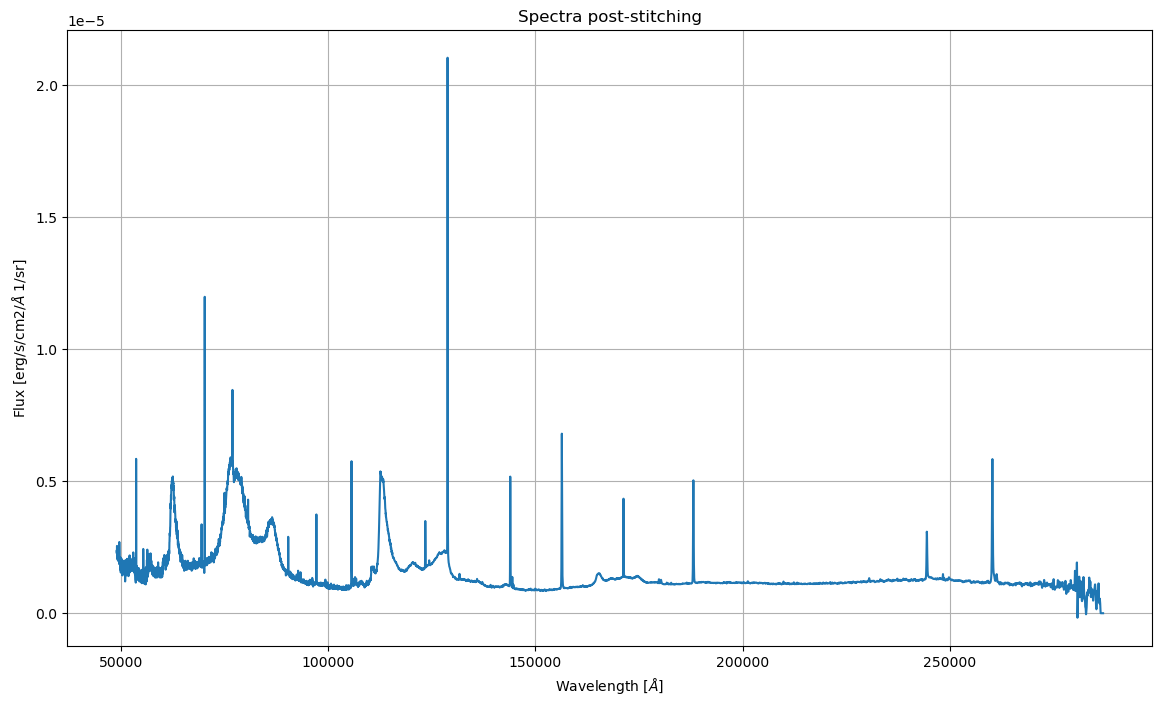

In [39]:
plt.figure(figsize=(14, 8))

spec = 0
err = 0
for ix in range(im2.shape[1]):
    for iy in range(im2.shape[0]):
        if (ix-x0)**2 + (iy-y0)**2 <= r**2:
            spec += final_flux[:,iy,ix]
            err += final_err[:,iy,ix]

plt.plot(final_wave*1e4,spec*1e6*1e-23* (c.to(u.AA/u.s)).value  /(stitched_wave*1e4)**2   )
   
# plt.xlim(5e4,28e4)
# plt.ylim(0,5.1e-6)
# plt.xlim(5e4,10e4)
# plt.ylim(0,1.e-17)
plt.title('Spectra post-stitching')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [erg/s/cm2/$\AA$ 1/sr]')
plt.grid()

plt.show()


# 4. Final interpolation #
Currently, 'cube_4plots' contains spectra with varying delta_lambda values (depending on the different channels).
We want to obtain a uniformly sampled spectral axis.
To do this, we use the largest wavelength step (delta_lambda) among the input spectra.
\
We also plot an histogramm to check the relative error in each spaxel during this step.

Central pixel of the valid region: 17 19


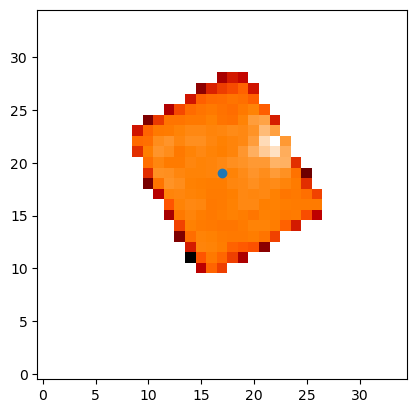

New wavelength array: [ 4.9004001  4.9064001  4.9124001 ... 28.6904003 28.6964003 28.7024003]
New interpolated spectral cube shape: (3968, 35, 35)

=== Flux Conservation Check at Pixel (19, 17) ===
Original total flux   : 2.220322e+04
Interpolated total flux: 2.220091e+04
Relative difference    : -0.0104%


In [40]:
# We use a pixel coordinates for the flux conservation check: it has to be a central spaxel, 
# with signal in all the channels, so we take the central spaxel of a Ch1 image
image2D = np.nansum(aligned_cubes[0], axis=0)  ## Ch1A image
mask_valid = (~np.isnan(image2D)) & (image2D != 0.)
y_valid, x_valid = np.where(mask_valid)

# find the central pixel
x_center = int((x_valid.min() + x_valid.max()) / 2)
y_center = int((y_valid.min() + y_valid.max()) / 2)

print("Central pixel of the valid region:", x_center, y_center)
plt.imshow(np.log10(image2D), origin='lower', cmap='gist_heat')
plt.scatter(x_center, y_center)
plt.show()

check_pixel = (y_center, x_center)  

# Compute the maximum wavelength step ===
delta_wl = np.diff(stitched_wave)
delta_final = delta_wl[-1]  # Use the largest wavelength step

#  Create a new wavelength array with uniform spacing
new_wl_array = np.arange(stitched_wave[0], stitched_wave[-1] + delta_final, delta_final)

#  Pre-allocate interpolated cubes
flux_interpolated = np.zeros((len(new_wl_array), cube_4plots.shape[1], cube_4plots.shape[2]))
error_interpolated = np.zeros((len(new_wl_array), error_4plots.shape[1], error_4plots.shape[2]))

# Loop over spatial pixels and interpolate spectra
for i in range(cube_4plots.shape[1]):
    for j in range(cube_4plots.shape[2]):
        spectrum = cube_4plots[:, i, j]
        error_spectrum = error_4plots[:, i, j]

        # Flux-conserving interpolation
        flux_interpolated[:, i, j] = spectres(new_wl_array, stitched_wave, spectrum)
        error_interpolated[:, i, j] = spectres(new_wl_array, stitched_wave, error_spectrum)

print("New wavelength array:", new_wl_array)
print("New interpolated spectral cube shape:", flux_interpolated.shape)


# Flux conservation check at selected pixel ===
i_check, j_check = check_pixel

# Original and interpolated spectrum at the selected pixel
spec_orig = cube_4plots[:, i_check, j_check]
spec_interp = flux_interpolated[:, i_check, j_check]

# Construct full wavelength step array (same length as spectrum)
delta_wl_full = np.append(delta_wl, delta_wl[-1])  # pad with last delta to match array length

# Compute total fluxes (flux * delta_lambda)
flux_orig_total = np.nansum(spec_orig * delta_wl_full)
flux_interp_total = np.nansum(spec_interp * delta_final)

# Print results
print(f"\n=== Flux Conservation Check at Pixel ({j_check}, {i_check}) ===")
print(f"Original total flux   : {flux_orig_total:.6e}")
print(f"Interpolated total flux: {flux_interp_total:.6e}")
print(f"Relative difference    : {(flux_interp_total - flux_orig_total) / flux_orig_total * 100:.4f}%")

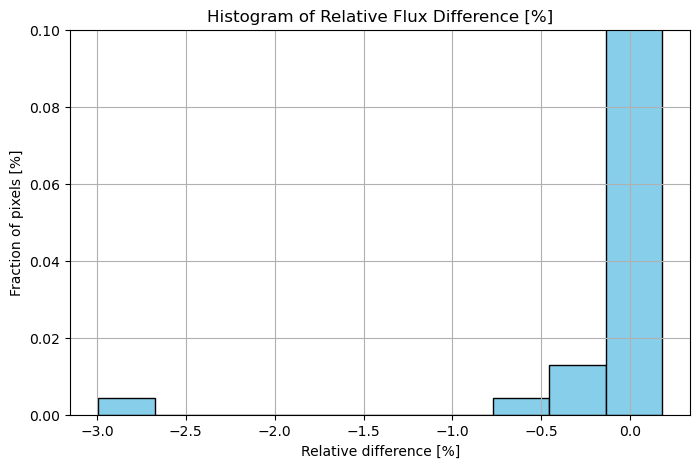

In [41]:
### Histogram of the relative differences
# Reshape cubes to (N_lambda, N_pixels)
cube_orig_2d = cube_4plots.reshape(cube_4plots.shape[0], -1)          # (N_lambda, N_pixels)
cube_interp_2d = flux_interpolated.reshape(flux_interpolated.shape[0], -1)  # (N_lambda_interp, N_pixels)
# Build full wavelength step array (length = N_lambda original)
delta_wl_full = np.append(delta_wl, delta_wl[-1])  # (N_lambda,)
delta_wl_full = delta_wl_full[:, np.newaxis]       # (N_lambda, 1)
# Ensure delta_final is an array (N_lambda_interp,)
delta_finals = float(np.copy(delta_final))
if np.isscalar(delta_finals):
    delta_finals = np.full(flux_interpolated.shape[0], delta_finals)
delta_finals = delta_finals[:, np.newaxis]           # (N_lambda_interp, 1)

# === Calculate total fluxes ===
flux_tot_orig = np.nansum(cube_orig_2d * delta_wl_full, axis=0)      # (N_pixels,)
flux_tot_interp = np.nansum(cube_interp_2d * delta_final, axis=0)    # (N_pixels,)
# === Compute relative difference in percentage ===
with np.errstate(divide='ignore', invalid='ignore'):
    relative_diff_percent = (flux_tot_interp - flux_tot_orig) / flux_tot_orig * 100
# Select valid pixels (finite and original flux != 0)
valid = np.isfinite(relative_diff_percent) & (flux_tot_orig != 0)

# === Plot histogram of relative differences ===
diff_valid = relative_diff_percent[valid]
plt.figure(figsize=(8,5))
plt.hist(diff_valid, bins=10, color='skyblue', edgecolor='black', density=True)
plt.title("Histogram of Relative Flux Difference [%]")
plt.xlabel("Relative difference [%]")
plt.ylabel("Fraction of pixels [%]")
plt.ylim(0,0.1)  # opzionale
plt.grid(True)
plt.show()

# 5. Save everything #

- **Extension 0 (PRIMARY HDU):** Original header from the first input cube (no data).  
- **Extension 1 (FLUX):** Final stitched flux cube, ~4 - 28 µm, resampled to a common wavelength grid with updated WCS.  
- **Extension 2 (ERROR):** Uncertainty cube corresponding to the FLUX cube.  
- **Extension 3 (SCALING_FACTORs):** Scaling factors applied to each cube during stitching.  

All extensions share consistent WCS in spatial dimensions.

In [ ]:

first_hdu = fits.open(s3dfiles[0])[0]  # Primary HDU (extension 0)
flux_hdu = fits.ImageHDU(data=flux_interpolated, name='FLUX', header=header_fin)
flux_hdu.header['CRVAL3'] = min_wave  # Set CRVAL3 to the minimum wavelength of the final cube
flux_hdu.header['CDELT3'] = delta_final  # Set CDELT3 to the wavelength step of the worst cube if u convolve the flux
flux_hdu.header['CRPIX3'] = header_fin['CRPIX3'] 
err_hdu = fits.ImageHDU(data=error_interpolated, name='ERROR', header=header_fin)
err_hdu.header['CRVAL3'] = min_wave  # Set CRVAL3 to the minimum wavelength of the final cube
err_hdu.header['CDELT3'] = delta_final  # Set CDELT3 to the wavelength step of the worst cube if u convolve the flux
err_hdu.header['CRPIX3'] = header_fin['CRPIX3'] 

## add wcs
wcs_header = wcs_fin.to_header()  
flux_hdu.header.update(wcs_header)  
err_hdu.header.update(wcs_header) 

error_hdu = fits.ImageHDU(data=final_err, name='ERROR')
scale_hdu = fits.ImageHDU(data=scaling_factors, name='SCALING_FACTORs')
hdul = fits.HDUList([first_hdu, flux_hdu,err_hdu,scale_hdu])
output_filename = os.path.join(dire, 'stitched_cube.fits')
hdul.writeto(output_filename, overwrite=True)
print(f'Final stitched cube saved to {output_filename}')
